In [3]:
import os
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import umap
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from scotplus.solvers import SinkhornSolver
from scotplus.utils.alignment import compute_graph_distances, get_barycentre, FOSCTTM
import scanpy as sc
from collections import Counter
from scipy.stats import entropy
from scipy.optimize import linear_sum_assignment
from sklearn.preprocessing import StandardScaler

C:\Users\49152\anaconda3\envs\scotplus\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
print('Torch version: {}'.format(torch.__version__))
print('CUDA available: {}'.format(torch.cuda.is_available()))
print('CUDA version: {}'.format(torch.version.cuda))
print('CUDNN version: {}'.format(torch.backends.cudnn.version()))

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark=True

Torch version: 2.8.0+cu126
CUDA available: True
CUDA version: 12.6
CUDNN version: 91002


In [5]:
BASE_DIR = "C:/Users/49152/Downloads/Multi-omics/"
SCOT_IN = os.path.join(BASE_DIR, "SCOT_plus/input")
RNA_FILE = os.path.join(SCOT_IN, "transcriptomics_for_SCOT.csv")
PROT_FILE = os.path.join(SCOT_IN, "proteomics_for_SCOT.csv")
RNA_META = os.path.join(SCOT_IN, "transcriptomics_metadata.csv")
PROT_META = os.path.join(SCOT_IN, "proteomics_metadata.csv")
OUT_DIR = os.path.join(BASE_DIR, "SCOT_plus/AGW_results")

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda:0


In [7]:
# ======= 1) Load matrices and prepare sample×feature arrays =======
rna_df = pd.read_csv(RNA_FILE, index_col=0)   # index = Gene, columns = sampleIDs
# If your transcriptomics file has header 'Gene' as first col and then sample columns,
# reading with index_col=0 makes rows=genes; transpose to samples x genes:
rna = rna_df.T.copy()   # DataFrame: rows = samples, cols = genes

# Proteomics: rows = genes, cols = samples (if first column is 'Gene', set index)
prot_df = pd.read_csv(PROT_FILE, index_col=0)
prot = prot_df.copy().T  # want samples x proteins as DataFrame

# Basic checks
print("RNA shape (samples x genes):", rna.shape)
print("Prot shape (samples x proteins):", prot.shape)

# Ensure sample IDs and metadata exist if you need them
# Optional: sort samples for reproducibility
rna = rna.sort_index()
prot = prot.sort_index()

RNA shape (samples x genes): (82, 2000)
Prot shape (samples x proteins): (67, 1000)


In [8]:
rna_meta = pd.read_csv(RNA_META, index_col=0)
prot_meta = pd.read_csv(PROT_META, index_col=0)
merged_meta = pd.concat([rna_meta, prot_meta])
merged_meta = merged_meta[~merged_meta.index.duplicated(keep='first')]
print(merged_meta)

            Chip CellLine  DetectedGenes5  sizeFactor
SampleID                                             
05J_C10_D1   05J      C10          7758.0    2.367114
05J_C10_D3   05J      C10          6914.0    3.243054
05J_C10_D5   05J      C10          4084.0    0.164945
05J_C10_D7   05J      C10          4765.0    0.351075
05J_C10_D9   05J      C10          4902.0    0.668006
...          ...      ...             ...         ...
07J_SVEC_B4  07J     SVEC             NaN         NaN
07J_SVEC_B5  07J     SVEC             NaN         NaN
07J_SVEC_C3  07J     SVEC             NaN         NaN
07J_SVEC_C4  07J     SVEC             NaN         NaN
07J_SVEC_D6  07J     SVEC             NaN         NaN

[89 rows x 4 columns]


In [9]:
# Use .map() to assign cell_type based on merged_meta['CellLine']
rna['cell_type'] = rna.index.map(merged_meta['CellLine'])
prot['cell_type'] = prot.index.map(merged_meta['CellLine'])

In [10]:
Counter(rna['cell_type']),Counter(prot['cell_type'])

(Counter({'C10': 43, 'SVEC': 39}), Counter({'SVEC': 36, 'C10': 31}))

In [11]:
# retrieving numeric matrices
prot_mtx = prot.iloc[:, :-1]
rna_mtx = rna.iloc[:, :-1]
# Keep labels
rna_features = rna_mtx.columns
prot_features = prot_mtx.columns
rna_cells = rna_mtx.index
prot_cells = prot_mtx.index

In [12]:
# Simple mean-imputation per feature for proteomics
prot_mtx = prot_mtx.apply(lambda x: x.fillna(x.mean()), axis=0)

In [13]:
# L2-normalize per cell (row) to make RNA and protein scales comparable
rna_mtx = normalize(rna_mtx, axis=1).astype(np.float32)
prot_mtx = normalize(prot_mtx, axis=1).astype(np.float32)

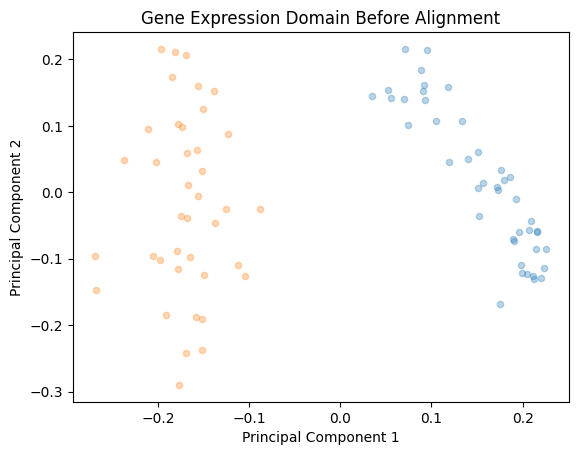

In [14]:
# visualize rna
label_array = np.array(rna['cell_type'].to_list())

unique_labels = np.unique(label_array)
rna_pca = PCA(n_components=2)
rna_pca.fit(rna_mtx)
rna_2Dpca = rna_pca.transform(rna_mtx)
plt.figure()

for label in unique_labels:
    subset = (label_array == label)
    plt.scatter(rna_2Dpca[subset, 0], rna_2Dpca[subset, 1], s=20, alpha=0.3, label=label)

# plt.legend(loc='best', shadow=False)
plt.title('Gene Expression Domain Before Alignment')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

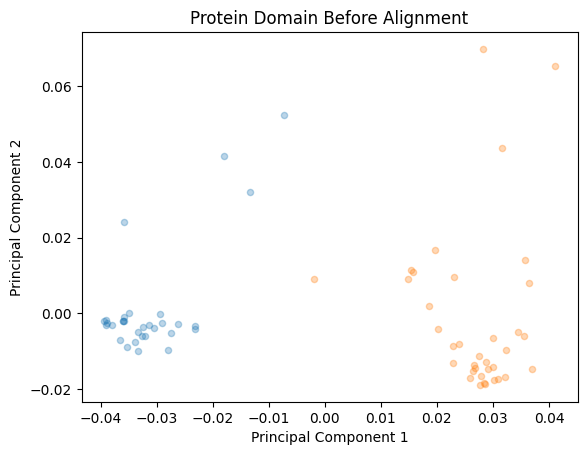

In [15]:
# visualize prot
label_array = np.array(prot['cell_type'].to_list())

unique_labels = np.unique(label_array)
prot_pca=PCA(n_components=2)
prot_2Dpca=prot_pca.fit_transform(prot_mtx)
plt.figure()

for label in unique_labels:
    subset = (label_array == label)
    plt.scatter(prot_2Dpca[subset, 0], prot_2Dpca[subset, 1], s=20, alpha=0.3, label=label)

# plt.legend(loc='best', shadow=False)
plt.title('Protein Domain Before Alignment')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

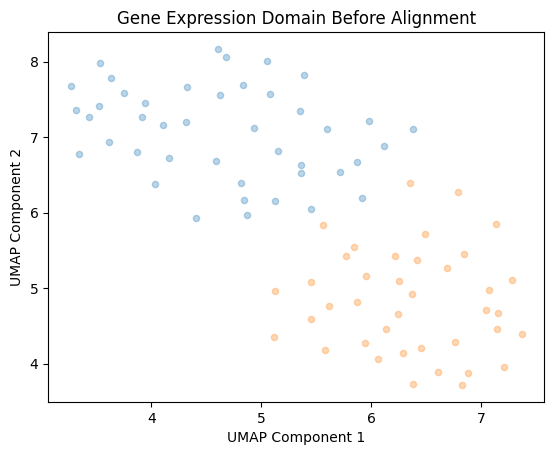

In [16]:
label_array = np.array(rna['cell_type'].to_list())

unique_labels = np.unique(label_array)
rna_umap=umap.UMAP(n_components=2, transform_seed=10)
rna_umap.fit(rna_mtx)
rna_2Dumap=rna_umap.transform(rna_mtx)
plt.figure()

for label in unique_labels:
    subset = (label_array == label)
    plt.scatter(rna_2Dumap[subset, 0], rna_2Dumap[subset, 1], s=20, alpha=0.3, label=label)

# plt.legend(loc='best', shadow=False)
plt.title('Gene Expression Domain Before Alignment')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()

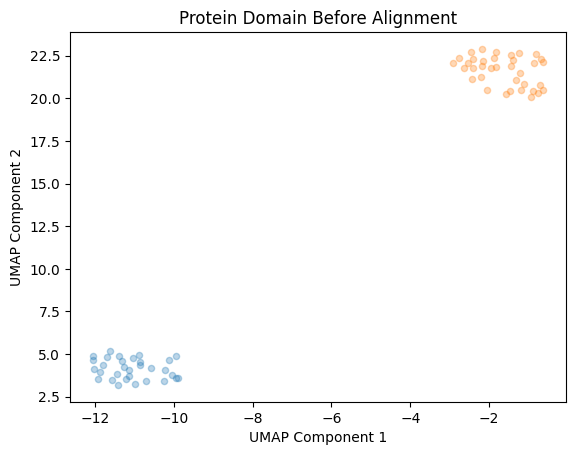

In [17]:
label_array = np.array(prot['cell_type'].to_list())

unique_labels = np.unique(label_array)
prot_umap=umap.UMAP(n_components=2)
prot_2Dumap=prot_umap.fit_transform(prot_mtx)
plt.figure()

for label in unique_labels:
    subset = (label_array == label)
    plt.scatter(prot_2Dumap[subset, 0], prot_2Dumap[subset, 1], s=20, alpha=0.3, label=label)

# plt.legend(loc='best', shadow=False)
plt.title('Protein Domain Before Alignment')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()

In [18]:
scot = SinkhornSolver(nits_uot=5000, tol_uot=1e-3, device=device)

In [19]:
# knn connectivity distance
D_prot_knn, D_rna_knn = torch.from_numpy(compute_graph_distances(prot_mtx, n_neighbors=5, mode='connectivity').astype('float32')).to(device), torch.from_numpy(compute_graph_distances(rna_mtx, n_neighbors=5, mode='connectivity').astype('float32')).to(device)

In [20]:
#Define epsilon
eps = 4.5e-4

In [21]:
# alpha grid from 0 (graph only) to 1 (features only)
alpha = 0.11

pi_samp_dt = {}
pi_feat_dt = {}

# Find sample IDs that exist in both omics
common_true = sorted(set(rna_cells).intersection(set(prot_cells)))
print(f"True shared sample count: {len(common_true)}")

# Map them to index order
rna_common_idx = np.array([list(rna_cells).index(sid) for sid in common_true])
prot_common_idx = np.array([list(prot_cells).index(sid) for sid in common_true])
print(rna_common_idx.shape, prot_common_idx.shape)

True shared sample count: 60
(60,) (60,)


BCD Iteration 1 - Loss: 0.003697, 0.004699
BCD Iteration 2 - Loss: 0.003698, 0.004699
(60, 1000) (60, 1000)
Mean FOSCTTM: 0.2912429378531074 for alpha 0.11
Random baseline FOSCTTM: 0.5192090395480224


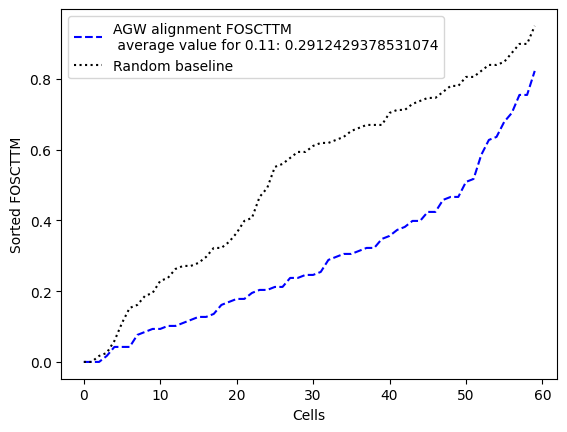

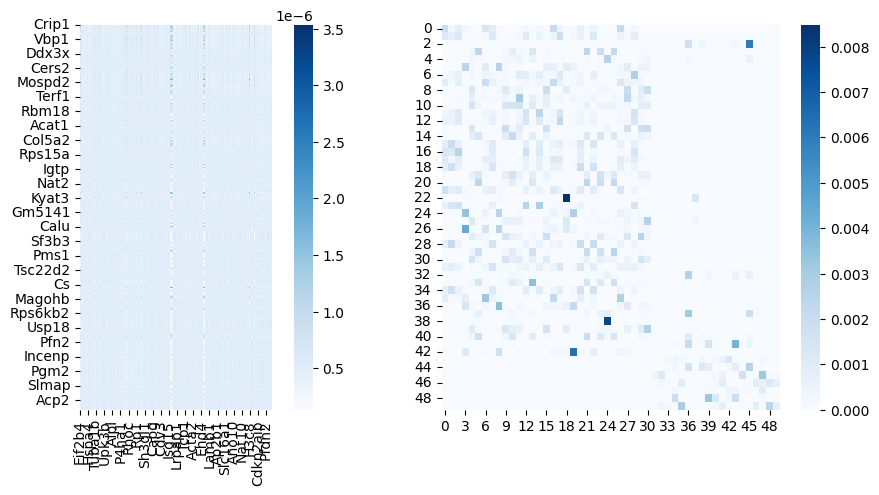

In [22]:
pi_samp_dt[alpha], _, pi_feat_dt[alpha] = scot.agw(rna_mtx, prot_mtx, D_rna_knn, D_prot_knn,alpha=alpha, eps=eps, verbose=True)
aligned_rna = get_barycentre(prot_mtx, pi_samp_dt[alpha], device = device)
rna_common = aligned_rna.cpu().numpy()[rna_common_idx, :]
prot_common = prot_mtx[prot_common_idx, :]
print(rna_common.shape, prot_common.shape)
fracs = FOSCTTM(prot_common, rna_common)
mean_fos = np.mean(fracs)
print("Mean FOSCTTM:", mean_fos, "for alpha", alpha)
perm = np.random.permutation(len(prot_common))
rand_fracs = FOSCTTM(prot_common[perm], rna_common)
print("Random baseline FOSCTTM:", np.mean(rand_fracs))
legend_label="AGW alignment FOSCTTM \n average value for {0}: ".format(alpha)+str(np.mean(fracs))
plt.plot(np.arange(len(fracs)), np.sort(fracs), "b--", label=legend_label)
plt.plot(np.arange(len(rand_fracs)), np.sort(rand_fracs), "k:", label="Random baseline")
plt.legend()
plt.xlabel("Cells")
plt.ylabel("Sorted FOSCTTM")
plt.show()
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
pi_feat_cpu = pi_feat_dt[alpha].detach().cpu().numpy()
sns.heatmap(pd.DataFrame(pi_feat_cpu,index=rna.columns[0:2000],columns=prot.columns[0:1000]),ax=ax1,cmap="Blues",square=True)
#sns.heatmap(pd.DataFrame(pi_feat_dt[val], index=rna.columns, columns=prot.columns), ax=ax1, cmap='Blues', square=True)
# looking at a corner to get a sense
pi_samp_cpu = pi_samp_dt[alpha].detach().cpu().numpy()
sns.heatmap(pd.DataFrame(pi_samp_cpu[:50, :50]),cmap='Blues')
plt.show()